import dependencies

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import numpy as np

Load & Clean

In [49]:
def load_total_generation(path, start_col, end_col):
    # 1) Read CSV, stripping spaces-as-thousands and treating '-' as NaN
    df = pd.read_csv(
        path,
        sep=';',
        thousands=' ',
        na_values='-'
    )
    col_to_drop = df.columns[8]
    df = df.drop(columns=[col_to_drop])
    # 2) Parse the date (first column) to a datetime index
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%b %d, %Y')
    df.set_index('date', inplace=True)

    # 3) Pull out just the source columns by position
    src = df.iloc[:, start_col:end_col]

    # 3) Clean & convert all those columns
    src = src.replace(',', '', regex=True).astype(float)

    # 4) Convert each to numeric (in case any remain as str)
    src = src.apply(lambda col: pd.to_numeric(col, errors='coerce'))

    # 5) Sum across those numeric columns
    df['TotalGeneration'] = src.sum(axis=1)


    # 6) Return the TotalGeneration series at daily freq
    return df['TotalGeneration'].asfreq('D')

# Example usage:
# If your first column is date, and the next 10 columns are all generation sources,
# then start_col=1, end_col=11
gen = load_total_generation(
    '../data/Actual_generation_202504140000_202504250000_Day.csv',
    start_col=2,
    end_col=12
)

print(gen.head())



date
2025-04-14    1098658.75
2025-04-15    1335042.50
2025-04-16    1113185.00
2025-04-17    1193970.25
2025-04-18     899248.75
Freq: D, Name: TotalGeneration, dtype: float64


In [50]:
def load_cons(path, value_col):
    df = pd.read_csv(path, sep=';')

    # 1) Parse the date in the first column
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%b %d, %Y')

    # 2) Clean numeric strings:
    #    - Replace '-' with NaN
    #    - Remove commas
    #    - Cast to float
    ser = df[value_col].replace('-', np.nan) \
                        .str.replace(',', '') \
                        .astype(float)

    # 3) Set index and enforce daily frequency
    ser.index = df['date']
    return ser.asfreq('D')


cons = load_cons(
    '../data/Actual_consumption_202504140000_202504250000_Day.csv',
    'grid load [MWh] Calculated resolutions'
)

In [51]:
cons.head()

date
2025-04-14    1257666.50
2025-04-15    1316285.50
2025-04-16    1297467.25
2025-04-17    1317192.25
2025-04-18    1074921.75
Freq: D, Name: grid load [MWh] Calculated resolutions, dtype: float64

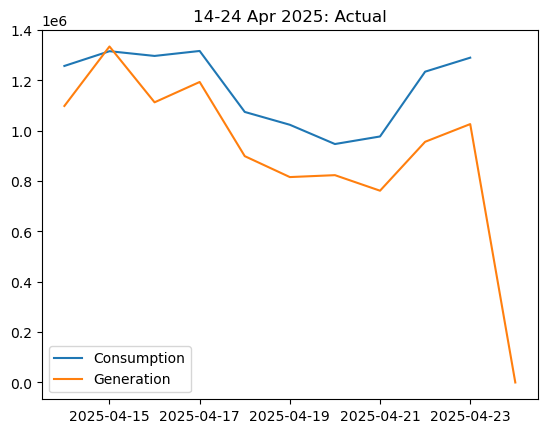

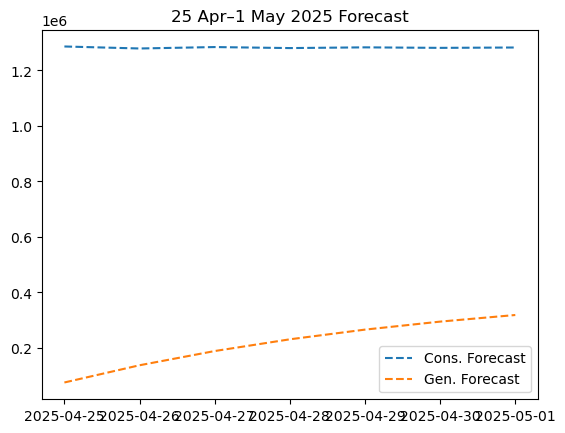

            Consumption_Forecast (MWh)  Generation_Forecast (MWh)
2025-04-25                   1286379.6                    75182.1
2025-04-26                   1279132.9                   137253.8
2025-04-27                   1284285.1                   188501.2
2025-04-28                   1280622.0                   230812.0
2025-04-29                   1283226.4                   265744.5
2025-04-30                   1281374.7                   294585.4
2025-05-01                   1282691.2                   318397.0


In [52]:


# 2) Visualize historical
plt.figure()
plt.plot(cons, label='Consumption')
plt.plot(gen,  label='Generation')
plt.title('14-24 Apr 2025: Actual')
plt.legend()
plt.show()

# 3) & 4) Fit ARIMA & forecast
def arima_forecast(series):
    model = ARIMA(series, order=(1,1,1)).fit()
    f = model.forecast(7)
    f.index = [series.index[-1] + timedelta(days=i) for i in range(1,8)]
    return f

cons_fc = arima_forecast(cons)
gen_fc  = arima_forecast(gen)

# plot forecasts
plt.figure()
plt.plot(cons_fc, '--', label='Cons. Forecast')
plt.plot(gen_fc,  '--', label='Gen. Forecast')
plt.title('25 Apr–1 May 2025 Forecast')
plt.legend()
plt.show()

# 5) Tabulate
forecast = pd.DataFrame({
    'Consumption_Forecast (MWh)': cons_fc,
    'Generation_Forecast (MWh)':  gen_fc
})
print(forecast.round(1))
